# ОБУЧЕНИЕ СЕМАНТИЧЕСКОЙ СЕГМЕНТАЦИИ

Структура:
- Validation, Validationannot - изображения и маски из валидационного сета в формате Camvid 1.0
- Train, Trainannot - соответственно из трейн сета

Доп файлы:
- label_colors.txt - цвета классов масок сегментаций из трейн и тест сета в формате Camvid 1.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import torch
import random
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import albumentations as albu
from PIL import Image
%matplotlib inline

In [2]:
pip install -U albumentations

In [3]:
pip install -U segmentation-models-pytorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [5]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Параметры

In [6]:
DATSET_NAME = "/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1"

X_TRAIN_DIR = f"{DATSET_NAME}/Train"
Y_TRAIN_DIR = f"{DATSET_NAME}/Trainannot"

X_VALID_DIR = f"{DATSET_NAME}/Validation"
Y_VALID_DIR = f"{DATSET_NAME}/Validationannot"

X_TEST_DIR = f"{DATSET_NAME}/Validation"
Y_TEST_DIR = f"{DATSET_NAME}/Validationannot"

LABEL_COLORS_FILE = f"{DATSET_NAME}/label_colors.txt"

Задание констант:

In [7]:
CLASSES = [
    "background",
    "valuny",
    "road"
]
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'softmax2d'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCHS = 70
BATCH_SIZE = 32

INIT_LR = 0.002
LR_DECREASE_STEP = 15
LR_DECREASE_COEF = 2 # LR будет разделен на этот коэф раз в LR_DECREASE_STEP эпох

INFER_WIDTH = 256
INFER_HEIGHT = 256

loss = utils.losses.DiceLoss()

# Вспомогательные функции

В данном примере в датасете на входе имеется трехканальная (так как 3 класса) фотка где в каждом пикселе стоит во всех каналах 0 кроме одного в котором 1. Тем самым кодируется класс конкретного пикселя в маске

In [8]:
def _convert_multichannel2singlechannel(mc_mask: np.ndarray):
    """ Осуществляет перевод трехканальной маски (число каналов сколько классов) в трехканальное
    изображение где будет расцветка как зададим в словаре colors_imshow для классов """

    colors_imshow = {
            "background" : np.array([0, 0, 0]),#черный
            "valuny": np.array([255, 96, 55]),#красный
            "road": np.array([0, 0, 255]), #синий
    }

    sc_mask = np.zeros((mc_mask[0].shape[0], mc_mask[0].shape[1], 3), dtype=np.uint8)
    square_ratios = {}

    for i, singlechannel_mask in enumerate(mc_mask):

        cls = CLASSES[i]
        singlechannel_mask = singlechannel_mask.squeeze()

        # Заодно осуществляет подсчет процента каждого класса (сумма пикселей на общее число)
        square_ratios[cls] = singlechannel_mask.sum() / singlechannel_mask.size

        sc_mask += np.multiply.outer(singlechannel_mask > 0, colors_imshow[cls]).astype(np.uint8)


    title = "Площади: " + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])
    return sc_mask, title


def visualize_multichennel_mask(img: np.ndarray, multichennel_mask: np.ndarray):
    """ Реализация демонстрации маски и самого изображения """
    # размер маски: H, W, CHANNEL
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    multichennel_mask = multichennel_mask.transpose(2, 0, 1)
    mask_to_show, title = _convert_multichannel2singlechannel(multichennel_mask)
    axes[1].imshow(mask_to_show)
    axes[1].set_title(title)

    plt.tight_layout()
    plt.show()

# Dataloader

In [91]:
class Dataset(BaseDataset):
    def __init__(
        self,
        images_dir,
        masks_dir,
        augmentation=None,
        preprocessing=None
    ):
        self.images_paths = sorted(glob(f"{images_dir}/*")) #принимает путь до изображений

        #print(self.images_paths,'/n')
        self.masks_paths = sorted(glob(f"{masks_dir}/*")) #принимает путь до масок
        #print(self.masks_paths,'/n')
        self.cls_colors = self._get_classes_colors(LABEL_COLORS_FILE) #поджимает значения файла с расшифровками цветов

        self.augmentation = augmentation #подхват аугментации
        self.preprocessing = preprocessing #нормализация: либо деление на 255 либо использование imagenet нормализацию
    def _get_classes_colors(self, label_colors_dir):
        cls_colors = {}
        with open(label_colors_dir) as file:
            while line := file.readline():
                R, G, B, label = line.rstrip().split()
                cls_colors[label] = np.array([B, G, R], dtype=np.uint8)

        keyorder = CLASSES
        cls_colors_ordered = {}
        for k in keyorder:
            if k in cls_colors:
                cls_colors_ordered[k] = cls_colors[k]
            elif k=="background":
                cls_colors_ordered[k] = np.array([0, 0, 0], dtype=np.uint8)
            else:
                raise ValueError(f"unexpected label {k}, cls colors: {cls_colors}")

        return cls_colors_ordered

    def __getitem__(self, i): #метод который выводит значение изображения и маски

        image = cv2.imread(self.images_paths[i]) #считывания изображения

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #превращение изображения из BGR в RGB,т.к. cv2 берет BGR по умолчанию

        mask = cv2.imread(self.masks_paths[i])

        masks = [cv2.inRange(mask, color, color) for color in self.cls_colors.values()]
        masks = [(m > 0).astype("float32") for m in masks]
        mask = np.stack(masks, axis=-1).astype("float")

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

    def __len__(self):
        return len(self.images_paths)

Демонстрация случайных фотографий тренировочного датасета с их масками:

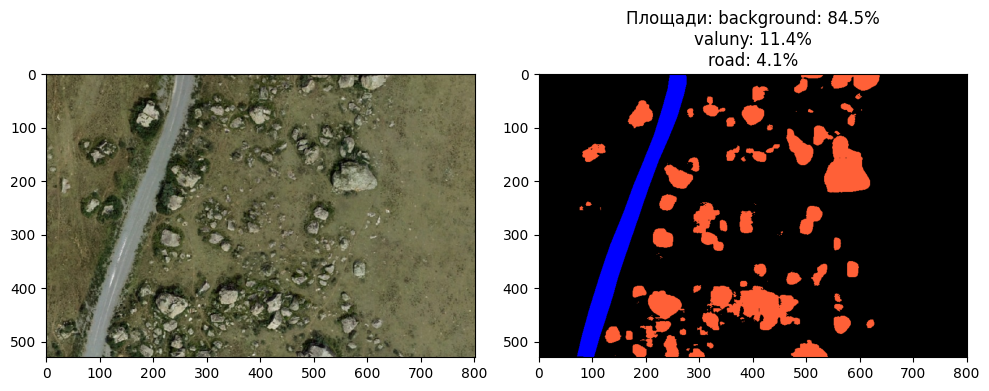

In [92]:
dataset = Dataset(X_TRAIN_DIR, Y_TRAIN_DIR)
dataset_new = Dataset(X_TRAIN_DIR, Y_TRAIN_DIR)
image, mask = dataset[np.random.randint(len(dataset))]
dataset1 =(image, mask)

visualize_multichennel_mask(dataset1[0], dataset1[1])



Демонстрация случайных фотографий валидационного датасета с их масками

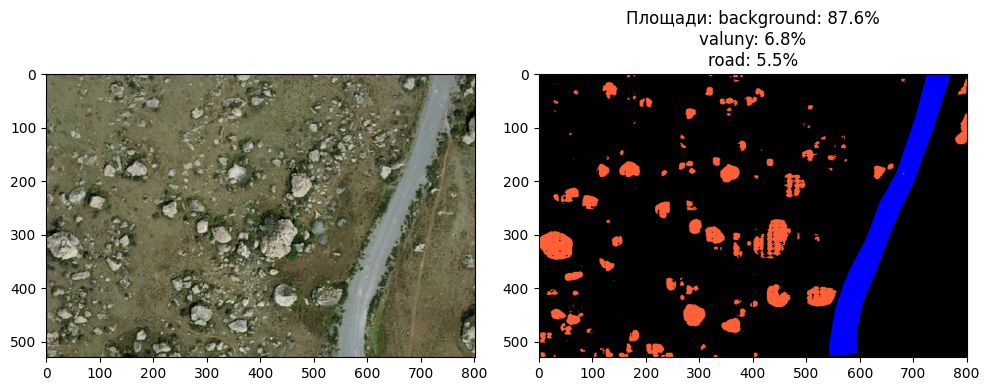

In [105]:
dataset = Dataset(X_VALID_DIR, Y_VALID_DIR)
dataset_new = Dataset(X_TRAIN_DIR, Y_TRAIN_DIR)
image, mask = dataset[np.random.randint(len(dataset))]
dataset1 =(image, mask)

visualize_multichennel_mask(dataset1[0], dataset1[1])


# Augmentations

In [106]:
def get_training_augmentation(): #раздел трейновых аугментаций
    train_transform = [

        albu.HorizontalFlip(p=0.5), #горизонтальное отображение

        albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
        albu.PadIfNeeded(min_height=int(INFER_HEIGHT*1.1), min_width=int(INFER_WIDTH*1.1), border_mode=2, always_apply=True),
        albu.RandomCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True),

        albu.OneOf(
            [
                albu.Sharpen(alpha=(0.1, 0.2), lightness=(0.1, 0.2), p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.Blur(blur_limit=[1, 3], p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.GaussNoise(var_limit=(1, 5), p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
            ],
            p=0.7,  # Уменьшение вероятности применения любой аугментации
        ),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
            ],
            p=0.7,  # Уменьшение вероятности применения любой аугментации цвета
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation(): #раздел валидационных аугментаций
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=2, always_apply=True),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    # Осуществит стартовую нормализацию данных согласно своим значениям или готовым для imagenet
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

Пример аугментаций на train:

<ipython-input-16-aa972e7ce57d>:6: UserWarning: Argument(s) 'always_apply' are not valid for transform MaxSizeTransform
  albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
<ipython-input-16-aa972e7ce57d>:7: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  albu.PadIfNeeded(min_height=int(INFER_HEIGHT*1.1), min_width=int(INFER_WIDTH*1.1), border_mode=2, always_apply=True),
<ipython-input-16-aa972e7ce57d>:8: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  albu.RandomCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True),
<ipython-input-16-aa972e7ce57d>:14: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  albu.GaussNoise(var_limit=(1, 5), p=0.5),  # Уменьшение вероятности и уменьшение интенсивности


['/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/Train/1.png', '/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/Train/13.jpg', '/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/Train/14.jpg', '/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/Train/15.jpg', '/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/Train/16.jpg', '/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/Train/17.jpg', '/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/Train/18.jpg', '/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/Train/23.jpg', '/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/Train/24.jpg', '/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/Train/25.jpg', '/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/Train/26.jpg', '/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/Train/27.jpg', '/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/Train/28.jpg', '/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/Train/29.jpg', '/content/drive/MyDr

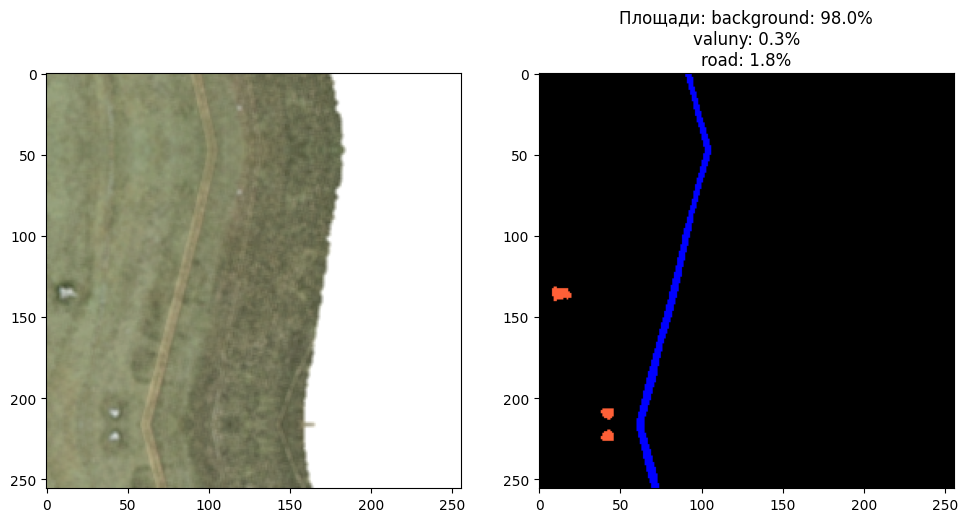

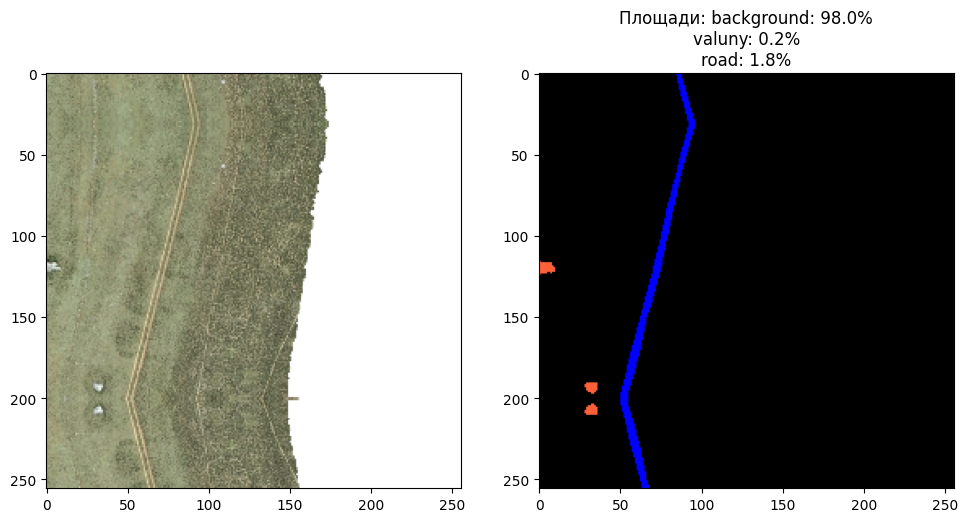

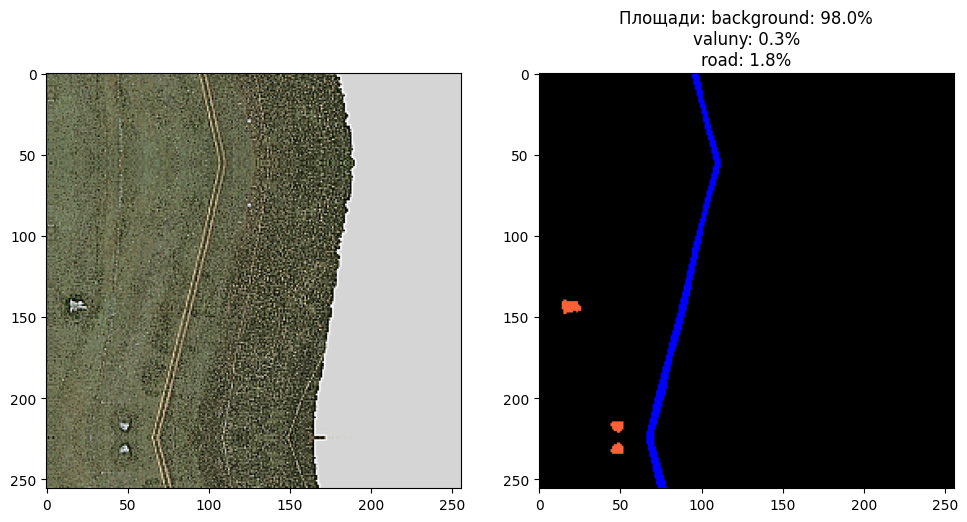

In [88]:
augmented_dataset = Dataset(
    X_TRAIN_DIR,
    Y_TRAIN_DIR,
    augmentation=get_training_augmentation()
)

# same image with different random transforms
indx = np.random.randint(len(augmented_dataset))

for i in range(3):
    image, mask = augmented_dataset[indx]
    visualize_multichennel_mask(image, mask)

Пример аугментаций на val:

<ipython-input-106-aa972e7ce57d>:31: UserWarning: Argument(s) 'always_apply' are not valid for transform MaxSizeTransform
  test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
<ipython-input-106-aa972e7ce57d>:32: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=2, always_apply=True),
<ipython-input-106-aa972e7ce57d>:33: UserWarning: Argument(s) 'always_apply' are not valid for transform CenterCrop
  albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]


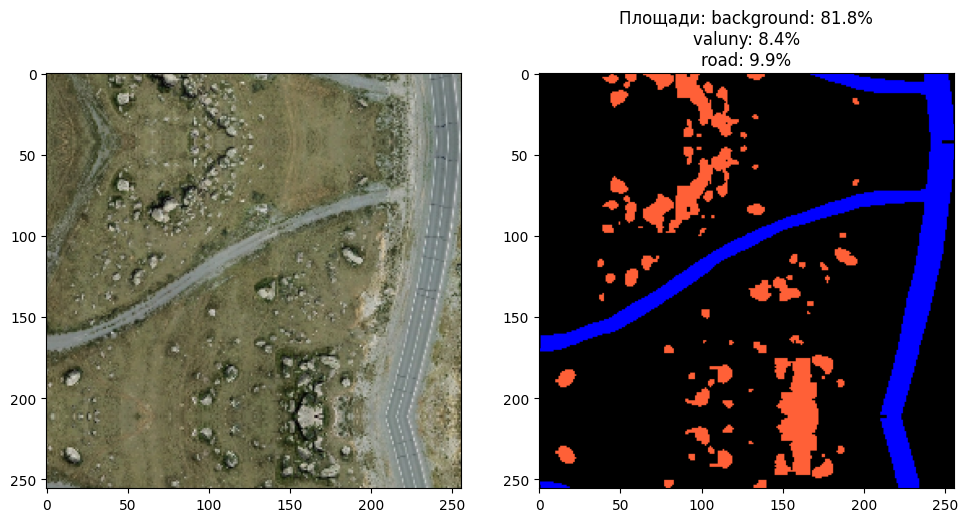

In [116]:
augmented_dataset = Dataset(
    X_VALID_DIR,
    Y_VALID_DIR,
    augmentation=get_validation_augmentation()
)

indx = np.random.randint(len(augmented_dataset))

image, mask = augmented_dataset[indx]
visualize_multichennel_mask(image, mask)

# Create model and train

In [136]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

In [137]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Загрузка нормализации от imagenet

In [138]:
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
#preprocessing_fn = lambda img, **kwargs: img.astype("float32") / 255    # -- классика деление на 255

In [139]:
preprocessing_fn

functools.partial(<function preprocess_input at 0x7fc1e311ede0>, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [140]:
train_dataset = Dataset( #подключение к трейн
    X_TRAIN_DIR,
    Y_TRAIN_DIR,
    #augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = Dataset( #подключение к вал
    X_VALID_DIR,
    Y_VALID_DIR,
    #augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True) #значение батч-сайз может меняться в зависимости от мощности видеокарты пользователя и количества изображений
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [141]:
#
metrics = [
    utils.metrics.Fscore(),
    utils.metrics.IoU()
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=INIT_LR),
])

In [142]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

Обучение:

In [ ]:
max_score = 0

loss_logs = {"train": [], "val": []}
metric_logs = {"train": [], "val": []}
for i in range(0, EPOCHS): #каждый раз гонит через функцию train.epoch.run и valid.epoch.run, считает метрики

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    train_loss, train_metric, train_metric_IOU = list(train_logs.values())
    loss_logs["train"].append(train_loss)
    metric_logs["train"].append(train_metric_IOU)

    valid_logs = valid_epoch.run(valid_loader)
    val_loss, val_metric, val_metric_IOU = list(valid_logs.values())
    loss_logs["val"].append(val_loss)
    metric_logs["val"].append(val_metric_IOU)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']: #сохранение наибольшего значения IOU
        max_score = valid_logs['iou_score']
        torch.save(model, '/content/drive/MyDrive/Colab_Notebooks/test_3_masks/models/4_best_model_new.pth')
        # Save the model with JIT
        # Create a tensor with the specified dimensions
        trace_image = torch.randn(BATCH_SIZE, 3, INFER_HEIGHT, INFER_WIDTH)
        # Trace the model using the example input
        traced_model = torch.jit.trace(model, trace_image.to(DEVICE)) #
        torch.jit.save(traced_model, '/content/drive/MyDrive/Colab_Notebooks/test_3_masks/models/4_best_model_new.pt')
        print('Model saved!')

    print("LR:", optimizer.param_groups[0]['lr'])
    if i > 0 and i % LR_DECREASE_STEP == 0:
        print('Decrease decoder learning rate')
        optimizer.param_groups[0]['lr'] /= LR_DECREASE_COEF


Epoch: 0
train:   0%|          | 0/2 [00:02<?, ?it/s]


KeyboardInterrupt: 

Оценка обучения:

NameError: name 'loss_logs' is not defined

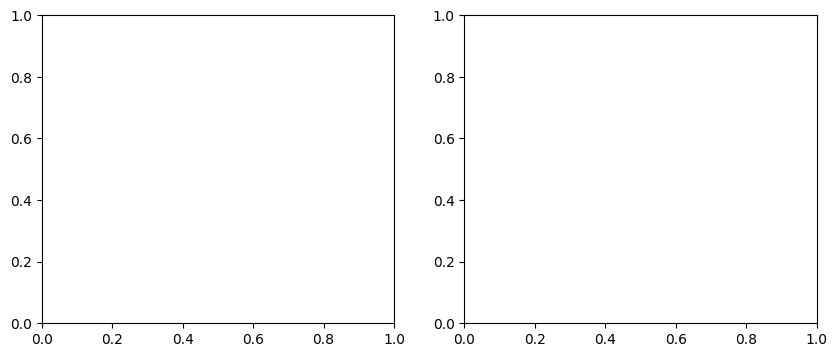

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(loss_logs["train"], label = "train")
axes[0].plot(loss_logs["val"], label = "val")
axes[0].set_title("losses - Dice")

axes[1].plot(metric_logs["train"], label = "train")
axes[1].plot(metric_logs["val"], label = "val")
axes[1].set_title("IOU")

[ax.legend() for ax in axes];

# Test best saved model

In [143]:
# load best saved checkpoint
#best_model = torch.load('/content/drive/MyDrive/Colab_Notebooks/test_3_masks/models/best_model_new.pth')
best_model = torch.jit.load('/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/models/4_best_model_new.pt', map_location=DEVICE)

In [144]:
def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=0, always_apply=True),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]
    return albu.Compose(test_transform)

In [145]:
# оценка IoU
test_dataset = Dataset(
    X_TEST_DIR,
    Y_TEST_DIR,
    #augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)

test_dataloader = DataLoader(test_dataset)

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 58/58 [01:36<00:00,  1.67s/it, dice_loss - 0.1508, fscore - 0.8518, iou_score - 0.8276]


# Visualize predictions

In [146]:
colors_imshow = {
        "background" : np.array([0, 0, 0]),
        "valuny" : np.array([255, 96, 55]),
        "road" : np.array([0, 0, 255])
    }


def _colorize_mask(mask: np.ndarray):
    mask = mask.squeeze()
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    square_ratios = {}
    for cls_code, cls in enumerate(CLASSES):
        cls_mask = mask == cls_code
        square_ratios[cls] = cls_mask.sum() / cls_mask.size
        colored_mask += np.multiply.outer(cls_mask, colors_imshow[cls]).astype(np.uint8)

    return colored_mask, square_ratios


def reverse_normalize(img, mean, std):
    # Invert normalization
    img = img * np.array(std) + np.array(mean)
    return img

In [147]:
def visualize_predicts(img: np.ndarray, mask_gt: np.ndarray, mask_pred: np.ndarray, normalized=False):
    # размер img: H, W, CHANNEl
    # размер mask_gt, mask_pred: H, W, значения - range(len(CLASSES)

    #n = 1

    _, axes = plt.subplots(1, 3, figsize=(10, 5))

    img = img.transpose(1, 2, 0)


    if normalized:

        # Отмените нормализацию, чтобы получить ненормализованное изображение

        img = reverse_normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    axes[0].imshow(img)

# переводим нормализованную в (0, 0.999) в целочисленную марицу рисунка в (0, 255)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f'/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/segmentation_results_1/images/image{n}.png', img * 256)



    mask_gt, square_ratios = _colorize_mask(mask_gt)

    title = "Площади:\n" + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])

    axes[1].imshow(mask_gt, cmap="twilight")

    axes[1].set_title(f"GT маска\n" + title)

    mask_pred, square_ratios = _colorize_mask(mask_pred)

    title = "Площади:\n" + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])

    axes[2].imshow(mask_pred, cmap="twilight")

    axes[2].set_title(f"PRED маска\n" + title)


    mask_gt = cv2.cvtColor(mask_gt, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f'/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/segmentation_results_1/masks_gt/mask_gt{n}.png', mask_gt)

    print(mask_gt[128,128,:])

    mask_pred = cv2.cvtColor(mask_pred, cv2.COLOR_BGR2RGB)
    cv2.imwrite(f'/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/segmentation_results_1/masks_pred/mask_pred{n}.png', mask_pred)

    plt.tight_layout()

    plt.show()

(530, 802) (3, 530, 802) (3, 530, 802)
[0 0 0]


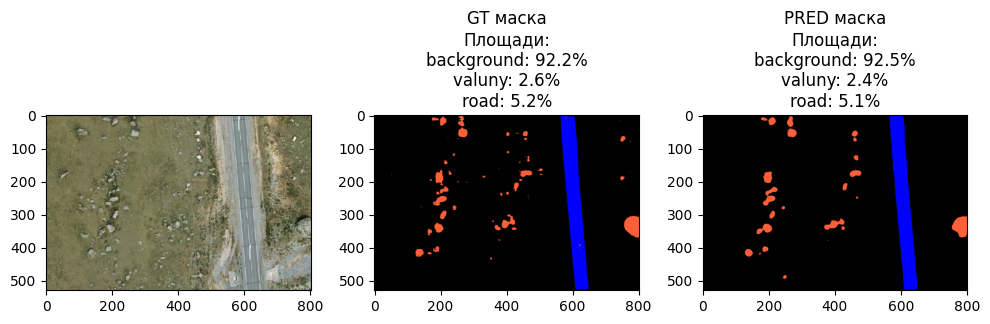

In [152]:
for i in range(1):
    n = np.random.choice(len(test_dataset))

    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model(x_tensor)
    pr_mask = pr_mask.squeeze().cpu().detach().numpy()

    label_mask = np.argmax(pr_mask, axis=0)
    print(label_mask.shape, image.shape, gt_mask.shape)

    visualize_predicts(image, np.argmax(gt_mask, axis=0), label_mask, normalized=True)


In [153]:
# Загрузка изображения маски
mask_path = f'/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/segmentation_results_1/masks_pred/mask_pred{n}.png'
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Проверка загрузки
if mask is None:
    raise ValueError("Не удалось загрузить маску!")

# 1. Анализ значений в маске
print("Уникальные значения в маске:", np.unique(mask))

# 2. Автоматическое определение классов (исключая 0 - фон)
unique_vals = [v for v in np.unique(mask) if v != 0]
if len(unique_vals) < 2:
    raise ValueError("В маске найдено меньше 2 классов!")

# Параметры классов (автоподбор)
classes1 = {
    'валуны': {
        'value': unique_vals[0],  # Первый ненулевой класс
        'color': (255, 0, 0)     # Синий
    },
    'дороги': {
        'value': unique_vals[1],  # Второй ненулевой класс
        'color': (0, 0, 255)     # Красный
    }
}

print("Определенные классы:", classes1)

# Создаем цветное изображение для контуров
img_contours = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

# Обработка каждого класса
for class_name, params in classes1.items():
    # Бинарная маска для класса
    binary_mask = np.uint8(mask == params['value']) * 255

    # Поиск контуров
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Рисуем контуры
    if contours:  # Если контуры найдены
        cv2.drawContours(img_contours, contours, -1, params['color'], 2)
        print(f"Найдено контуров для {class_name}: {len(contours)}")
    else:
        print(f"Контуры не найдены для {class_name}!")

# Сохранение и показ результата
output_path = f'/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/segmentation_results_1/masks_pred_counters/mask_pred_counters_new{n}.png'
cv2.imwrite(output_path, img_contours)

Уникальные значения в маске: [  0  29 138]
Определенные классы: {'валуны': {'value': np.uint8(29), 'color': (255, 0, 0)}, 'дороги': {'value': np.uint8(138), 'color': (0, 0, 255)}}
Найдено контуров для валуны: 1
Найдено контуров для дороги: 24


True

In [155]:
# Пути к файлам
mask_path = f'/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/segmentation_results_1/masks_pred_counters/mask_pred_counters_new{n}.png'
image_path = f'/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/segmentation_results_1/images/image{n}.png'

# Загрузка данных
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
original_image = cv2.imread(image_path)

# Проверка загрузки
if mask is None or original_image is None:
    raise ValueError("Ошибка загрузки файлов!")

# Приведение к одинаковому размеру
mask = cv2.resize(mask, (802, 530))
original_image = cv2.resize(original_image, (802, 530))

# Определяем классы автоматически
unique_vals = [v for v in np.unique(mask) if v != 0]
if len(unique_vals) < 2:
    raise ValueError("В маске меньше 2 классов!")

classes = {
    'валуны': {
        'value': unique_vals[0],
        'color': (255, 0, 0)  # Синий
    },
    'дороги': {
        'value': unique_vals[1],
        'color': (0, 0, 255)  # Красный
    }
}

# Создаем копию исходного изображения для рисования
result_map = original_image.copy()

# Обработка каждого класса
for class_name, params in classes.items():
    # Создаем бинарную маску класса
    binary_mask = np.uint8(mask == params['value']) * 255

    # Находим контуры
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Рисуем контуры на исходном изображении
    cv2.drawContours(result_map, contours, -1, params['color'], 2)


# Сохраняем результат
output_path = f'/content/drive/MyDrive/Colab_Notebooks/test_3_masks_1/segmentation_results_1/final_maps/final_map_{n}.png'
cv2.imwrite(output_path, result_map)


True

In [ ]:
!zip -r /content/drive/MyDrive/Colab_Notebooks/test_3_masks/test_3_masks.zip /content/drive/MyDrive/Colab_Notebooks/test_3_masks/

  adding: content/drive/MyDrive/Colab_Notebooks/test_3_masks/ (stored 0%)
  adding: content/drive/MyDrive/Colab_Notebooks/test_3_masks/.ipynb_checkpoints/ (stored 0%)
  adding: content/drive/MyDrive/Colab_Notebooks/test_3_masks/Train.txt (deflated 86%)
  adding: content/drive/MyDrive/Colab_Notebooks/test_3_masks/label_colors.txt (stored 0%)
  adding: content/drive/MyDrive/Colab_Notebooks/test_3_masks/Validation.txt (deflated 88%)
  adding: content/drive/MyDrive/Colab_Notebooks/test_3_masks/Train/ (stored 0%)
  adding: content/drive/MyDrive/Colab_Notebooks/test_3_masks/Train/4.jpg (deflated 0%)
  adding: content/drive/MyDrive/Colab_Notebooks/test_3_masks/Train/5.jpg (deflated 0%)
  adding: content/drive/MyDrive/Colab_Notebooks/test_3_masks/Train/6.jpg (deflated 0%)
  adding: content/drive/MyDrive/Colab_Notebooks/test_3_masks/Train/8.jpg (deflated 0%)
  adding: content/drive/MyDrive/Colab_Notebooks/test_3_masks/Train/7.jpg (deflated 0%)
  adding: content/drive/MyDrive/Colab_Notebooks/tes

ПРимер неправильной подготовки данных


---